In [46]:
# !pip install statsmodels

In [47]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [48]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_25_01.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Adding 'barcelona' column with values equal to 1
df['barcelona'] = 1

# Adding the 'event' column with values equal to 1
df['event'] = 1

# Display the DataFrame
print(df.shape)

(373, 10)


In [49]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_25_01.csv'

# Read the CSV file into a DataFrame
V1 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, V1.assign(barcelona=0, event=1)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)



Updated df after adding rows from V1:
(770, 10)


In [50]:
# # Specify the path to the CSV file
# file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_19_24.csv'

# # Read the CSV file into a DataFrame
# V0 = pd.read_csv(file_path)

# # Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 0
# df = pd.concat([df, V0.assign(barcelona=0, event=0)], ignore_index=True)

# # Displaying the updated df DataFrame
# print("\nUpdated df after adding rows from V1:")
# print(df.shape)

In [51]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_05_24_05_28.csv'

# Read the CSV file into a DataFrame (V0)
V0 = pd.read_csv(file_path)

# Filter the rows in V0 where 'Hotels' exists in the 'Hotels' column of V1
filtered_V0 = V0[V0['Hotels'].isin(V1['Hotels'])]

# Adding rows from filtered V0 to df with 'barcelona' values set to 0 and 'event' values set to 0
df = pd.concat([df, filtered_V0.assign(barcelona=0, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from filtered V0:")
print(df.shape)



Updated df after adding rows from filtered V0:
(923, 10)


In [52]:
# # Specify the path to the CSV file
# file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_19_24.csv'

# # Read the CSV file into a DataFrame
# B0 = pd.read_csv(file_path)

# # Adding rows from B0 to df with 'barcelona' values set to 1 and 'event' values set to 0
# df = pd.concat([df, B0.assign(barcelona=1, event=0)], ignore_index=True)

# # Displaying the updated df DataFrame
# print("\nUpdated df after adding rows from V1:")
# print(df.shape)
# print(df.columns)

In [53]:
import pandas as pd

# Specify the path to the CSV file (BO)
file_path_BO = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_05_24_05_28.csv'

# Read the CSV file into a DataFrame (BO)
B0 = pd.read_csv(file_path_BO)

# Filter the rows in BO where 'Hotels' exists in the 'Hotels' column of df
filtered_B0 = B0[B0['Hotels'].isin(df['Hotels'])]

# Adding rows from filtered BO to df with 'barcelona' values set to 1 and 'event' values set to 0
df = pd.concat([df, filtered_B0.assign(barcelona=1, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from filtered BO:")
print(df.shape)
print(df.columns)



Updated df after adding rows from filtered BO:
(1022, 10)
Index(['Hotels', 'Ratings', 'Distance', 'District', 'Price', 'Link', 'Star',
       'Descriptions', 'barcelona', 'event'],
      dtype='object')


In [54]:
# Create a DataFrame
df = pd.DataFrame(df)

In [55]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [56]:
# Extract only digits from the 'Price' column and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')

# Extract the first digit and convert to numeric
df['Star'] = pd.to_numeric(df['Star'].str.extract('(\d)', expand=False), errors='coerce')

# Display the updated DataFrame
print(df.head())

                                Hotels Ratings             Distance  District  \
0         apartment next to park guell     9,0  a 2,7 km del centro       NaN   
1           Melia Barcelona Sky 4* Sup     8,2  a 3,3 km del centro       NaN   
2                Nice room By Eixample     6,7  a 1,3 km del centro       NaN   
3         Mercedes Heritage Apartments     8,5  a 1,5 km del centro       NaN   
4  Gran Hotel La Florida G.L Monumento     8,7  a 5,9 km del centro       NaN   

   Price                                               Link  Star  \
0   1608  https://www.booking.com/hotel/es/apartment-par...     4   
1   3343  https://www.booking.com/hotel/es/melia-barcelo...     4   
2    687  https://www.booking.com/hotel/es/nice-room-for...     5   
3   3565  https://www.booking.com/hotel/es/provenza-mbs....     2   
4   1963  https://www.booking.com/hotel/es/gran-la-flori...     4   

                                        Descriptions  barcelona  event  
0  Apartment next to park

In [57]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [58]:
# Display the count of NaN values in each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hotels        1022 non-null   object 
 1   Ratings       1022 non-null   object 
 2   Distance      1022 non-null   object 
 3   District      0 non-null      float64
 4   Price         1022 non-null   int64  
 5   Link          1022 non-null   object 
 6   Star          1022 non-null   int64  
 7   Descriptions  1019 non-null   object 
 8   barcelona     1022 non-null   int64  
 9   event         1022 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 80.0+ KB
None


In [59]:
# Group the DataFrame by 'barcelona' and 'event' columns and calculate the mean of 'Price'
result = df.groupby(['barcelona', 'event'])['Price'].mean().reset_index()

# Order the result DataFrame by the 'Star' column
# result = result.sort_values(by=['Star'])

# 'result' will now contain the average 'Price' for each combination of 'barcelona' and 'event'
print(result)

   barcelona  event        Price
0          0      0   659.549020
1          0      1   722.267003
2          1      0   827.525253
3          1      1  1857.469169


In [60]:
# Count the occurrences of each unique value in the 'Star' column
star_counts = df['Star'].value_counts()

# Print the count of values for each unique 'Star'
print(star_counts)

Star
4    538
3    342
2     88
1     36
5     18
Name: count, dtype: int64


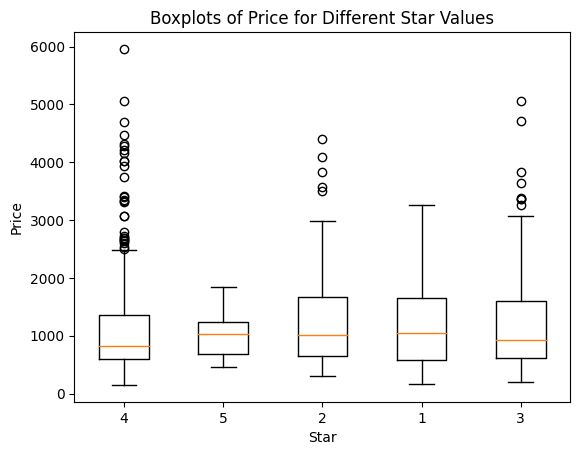

In [61]:
# Group the DataFrame by the 'Star' column and create boxplots for each group
plt.boxplot([df['Price'][df['Star'] == star] for star in df['Star'].unique()], 
            labels=df['Star'].unique())
plt.xlabel('Star')
plt.ylabel('Price')
plt.title('Boxplots of Price for Different Star Values')
plt.show()

In [62]:
# Independent variables
X = df[['barcelona']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.647
Model:                            OLS   Adj. R-squared (uncentered):              0.647
Method:                 Least Squares   F-statistic:                              1872.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                   3.57e-233
Time:                        23:03:45   Log-Likelihood:                         -8311.7
No. Observations:                1022   AIC:                                  1.663e+04
Df Residuals:                    1021   BIC:                                  1.663e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [63]:
# Independent variables
X = df[['event']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.634
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                              1770.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                   3.74e-225
Time:                        23:03:45   Log-Likelihood:                         -8330.2
No. Observations:                1022   AIC:                                  1.666e+04
Df Residuals:                    1021   BIC:                                  1.667e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [64]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.794
Method:                 Least Squares   F-statistic:                              1315.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                        0.00
Time:                        23:03:45   Log-Likelihood:                         -8034.8
No. Observations:                1022   AIC:                                  1.608e+04
Df Residuals:                    1019   BIC:                                  1.609e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [65]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model without adding a constant term
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     308.5
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          1.93e-142
Time:                        23:03:45   Log-Likelihood:                -7942.7
No. Observations:                1022   AIC:                         1.589e+04
Df Residuals:                    1018   BIC:                         1.591e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              659.5490     46.503  

In [66]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     237.0
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          8.63e-144
Time:                        23:03:45   Log-Likelihood:                -7936.6
No. Observations:                1022   AIC:                         1.588e+04
Df Residuals:                    1017   BIC:                         1.591e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              377.5489     93.022  

In [67]:
# Create a new column 'Top_star' based on the condition
df['Top_star'] = (df['Star'].isin([4, 5])).astype(int)


In [74]:
# Calculate the number of observations meeting the specified conditions
num_observations = df[(df['barcelona'] == 1) & (df['Top_star'] == 1) & (df['event'] == 1)].shape[0]

# Display the result
print("Number of observations:", num_observations)

Number of observations: 156


In [75]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     235.4
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          4.69e-143
Time:                        23:05:35   Log-Likelihood:                -7938.3
No. Observations:                1022   AIC:                         1.589e+04
Df Residuals:                    1017   BIC:                         1.591e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              591.5807     51.694  

In [76]:
# Adding interaction terms
df['interaction_term'] = df['barcelona'] * df['event']
df['interaction_term_all'] = df['barcelona'] * df['event'] * df['Top_star']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term', 'interaction_term_all']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     190.5
Date:                Tue, 30 Jan 2024   Prob (F-statistic):          3.31e-143
Time:                        23:05:49   Log-Likelihood:                -7935.1
No. Observations:                1022   AIC:                         1.588e+04
Df Residuals:                    1016   BIC:                         1.591e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  636.3476 